In [1]:
# Global imports
import os
import numpy as np
import pandas as pd
import imageio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import tensorflow_addons as tfa

c:\Users\herna\anaconda3\envs\SpectroCNN\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\herna\anaconda3\envs\SpectroCNN\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an is

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [6]:
# mport train
df_train = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/train_split_Depression_AVEC2017.csv')
df_test = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/test_split_Depression_AVEC2017.csv')
df_test_full = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/full_test_split.csv')
df_dev = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/dev_split_Depression_AVEC2017.csv')

In [7]:
# See head
df_train.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,303,0,0,0,0,0,0.0,0,0,0,0,0
1,304,0,6,0,0,1,1.0,2,2,0,0,0
2,305,0,7,1,0,1,1.0,2,2,1,0,0
3,310,0,4,1,1,1,0.0,0,0,1,1,0
4,312,0,2,1,0,0,1.0,1,0,0,0,0


In [8]:
# See head
df_test.head()

,participant_ID,Gender
0,300,1
1,301,1
2,306,0
3,308,0
4,309,1


In [9]:
# See head
df_test_full.head()

,Participant_ID,PHQ_Binary,PHQ_Score,Gender
0,300,0,2,1
1,301,0,3,1
2,306,0,0,0
3,308,1,22,0
4,309,1,15,1


In [10]:
# See head
df_dev.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,302,0,4,1,1,1,0,1,0,1,0,0
1,307,0,4,0,0,1,0,1,0,2,0,0
2,331,0,8,1,1,1,1,1,1,1,1,1
3,335,1,12,0,1,1,3,2,3,1,1,0
4,346,1,23,0,2,3,3,3,3,3,3,3


In [11]:
# Check if all data seems ok
print(df_train.shape[0], df_test_full.shape[0], df_dev.shape[0], df_train.shape[0]+ df_test_full.shape[0]+ df_dev.shape[0])

107 47 35 189


In [12]:
# Define root path of data
root_path = 'd:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data'  # Replace with your root path

# Add the column for spectrogram
if 'Spectrogram' not in df_test.columns:
    df_test['Spectrogram'] = None

# Iterate over the train dataframe to add the image information to the df
for index, row in df_test.iterrows():
    participant_id = str(int(row['participant_ID']))
    folder_path = os.path.join(root_path, str(participant_id)+'_P')

    if os.path.isdir(folder_path):
        image_path = os.path.join(folder_path, 'resized_spectrogram_preprocessed_'+str(participant_id)+'_AUDIO.jpg')  # Replace with your image name
        print(image_path)
        if os.path.isfile(image_path):
            image = imageio.imread(image_path)
            df_test.at[index, 'Spectrogram'] = image

d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\300_P\resized_spectrogram_preprocessed_300_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\301_P\resized_spectrogram_preprocessed_301_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\306_P\resized_spectrogram_preprocessed_306_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\308_P\resized_spectrogram_preprocessed_308_AUDIO.jpg


C:\Users\herna\AppData\Local\Temp\ipykernel_12712\3453914316.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\309_P\resized_spectrogram_preprocessed_309_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\311_P\resized_spectrogram_preprocessed_311_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\314_P\resized_spectrogram_preprocessed_314_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\323_P\resized_spectrogram_preprocessed_323_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\329_P\resized_spectrogram_preprocessed_329_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\332_P\resized_spectrogram_preprocessed_332_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\334_P\resized_spectrogram_preprocessed_334_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\337_P\resized_spectrogram_preprocessed_337_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\349_P\resized_spectrogram_preprocessed_349_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WO

In [13]:
df_test_full

,Participant_ID,PHQ_Binary,PHQ_Score,Gender
0,300,0,2,1
1,301,0,3,1
2,306,0,0,0
3,308,1,22,0
4,309,1,15,1
5,311,1,21,0
6,314,0,1,0
7,323,0,1,0
8,329,0,1,1
9,332,1,18,0


In [14]:
x_test = df_test['Spectrogram']
y_test = df_test_full['PHQ_Binary']

In [15]:
# Define root path of data
root_path = 'd:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data'  # Replace with your root path

# Add the column for spectrogram
if 'Spectrogram' not in df_train.columns:
    df_train['Spectrogram'] = None
    
# Iterate over the train dataframe to add the image information to the df
for index, row in df_train.iterrows():
    participant_id = str(int(row['Participant_ID']))
    folder_path = os.path.join(root_path, str(participant_id)+'_P')
    
    if os.path.isdir(folder_path):
        image_path = os.path.join(folder_path, 'resized_spectrogram_preprocessed_'+str(participant_id)+'_AUDIO.jpg')  # Replace with your image name
        print(image_path)
        if os.path.isfile(image_path):
            image = imageio.imread(image_path)
            df_train.at[index, 'Spectrogram'] = image

d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\303_P\resized_spectrogram_preprocessed_303_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\304_P\resized_spectrogram_preprocessed_304_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\305_P\resized_spectrogram_preprocessed_305_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\310_P\resized_spectrogram_preprocessed_310_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\312_P\resized_spectrogram_preprocessed_312_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\313_P\resized_spectrogram_preprocessed_313_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\315_P\resized_spectrogram_preprocessed_315_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\316_P\resized_spectrogram_preprocessed_316_AUDIO.jpg


C:\Users\herna\AppData\Local\Temp\ipykernel_12712\2740255739.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\317_P\resized_spectrogram_preprocessed_317_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\318_P\resized_spectrogram_preprocessed_318_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\319_P\resized_spectrogram_preprocessed_319_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\320_P\resized_spectrogram_preprocessed_320_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\321_P\resized_spectrogram_preprocessed_321_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\322_P\resized_spectrogram_preprocessed_322_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\324_P\resized_spectrogram_preprocessed_324_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\325_P\resized_spectrogram_preprocessed_325_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\326_P\resized_spectrogram_preprocessed_326_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WO

In [16]:
df_train.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving,Spectrogram
0,303,0,0,0,0,0,0.0,0,0,0,0,0,"[[[7, 0, 7], [5, 0, 6], [5, 0, 13], [5, 0, 16]..."
1,304,0,6,0,0,1,1.0,2,2,0,0,0,"[[[1, 0, 5], [1, 0, 5], [1, 0, 5], [1, 0, 5], ..."
2,305,0,7,1,0,1,1.0,2,2,1,0,0,"[[[2, 1, 0], [4, 2, 7], [3, 0, 27], [29, 23, 4..."
3,310,0,4,1,1,1,0.0,0,0,1,1,0,"[[[0, 0, 4], [0, 0, 4], [0, 0, 4], [0, 0, 4], ..."
4,312,0,2,1,0,0,1.0,1,0,0,0,0,"[[[3, 2, 10], [2, 1, 9], [0, 0, 5], [15, 14, 1..."


In [17]:
# Add the column for spectrogram
if 'Spectrogram' not in df_dev.columns:
    df_dev['Spectrogram'] = None
    
# Iterate over the train dataframe to add the image information to the df
for index, row in df_dev.iterrows():
    participant_id = str(int(row['Participant_ID']))
    folder_path = os.path.join(root_path, str(participant_id)+'_P')
    
    if os.path.isdir(folder_path):
        image_path = os.path.join(folder_path, 'resized_spectrogram_preprocessed_'+str(participant_id)+'_AUDIO.jpg')  # Replace with your image name
        print(image_path)
        if os.path.isfile(image_path):
            image = imageio.imread(image_path)
            df_dev.at[index, 'Spectrogram'] = image

d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\302_P\resized_spectrogram_preprocessed_302_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\307_P\resized_spectrogram_preprocessed_307_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\331_P\resized_spectrogram_preprocessed_331_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\335_P\resized_spectrogram_preprocessed_335_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\346_P\resized_spectrogram_preprocessed_346_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\367_P\resized_spectrogram_preprocessed_367_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\377_P\resized_spectrogram_preprocessed_377_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\381_P\resized_spectrogram_preprocessed_381_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\382_P\resized_spectrogram_preprocessed_382_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WO

C:\Users\herna\AppData\Local\Temp\ipykernel_12712\1272471068.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\389_P\resized_spectrogram_preprocessed_389_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\390_P\resized_spectrogram_preprocessed_390_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\395_P\resized_spectrogram_preprocessed_395_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\403_P\resized_spectrogram_preprocessed_403_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\404_P\resized_spectrogram_preprocessed_404_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\406_P\resized_spectrogram_preprocessed_406_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\413_P\resized_spectrogram_preprocessed_413_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\417_P\resized_spectrogram_preprocessed_417_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\418_P\resized_spectrogram_preprocessed_418_AUDIO.jpg
d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WO

In [18]:
df_dev.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving,Spectrogram
0,302,0,4,1,1,1,0,1,0,1,0,0,"[[[2, 0, 22], [0, 0, 12], [6, 6, 8], [1, 1, 3]..."
1,307,0,4,0,0,1,0,1,0,2,0,0,"[[[11, 0, 37], [43, 34, 63], [2, 0, 11], [3, 5..."
2,331,0,8,1,1,1,1,1,1,1,1,1,"[[[0, 0, 4], [0, 0, 4], [0, 0, 4], [0, 0, 4], ..."
3,335,1,12,0,1,1,3,2,3,1,1,0,"[[[0, 3, 0], [0, 2, 1], [0, 1, 3], [0, 1, 5], ..."
4,346,1,23,0,2,3,3,3,3,3,3,3,"[[[0, 0, 5], [0, 0, 5], [0, 0, 4], [0, 0, 4], ..."


In [19]:
df_train.iloc[[1]]['Spectrogram'][1].shape

(252, 792, 3)

In [20]:
depressed_count = df_train['PHQ8_Depressed'].sum()
non_depressed_count = len(df_train) - depressed_count

print("Number of depressed instances:", depressed_count)
print("Number of non-depressed instances:", non_depressed_count)

Number of depressed instances: 86
Number of non-depressed instances: 21


In [21]:
df_train[df_train['PHQ8_Depressed'] == 1].count()

Participant_ID        43
PHQ8_Binary           43
PHQ8_Score            43
Gender                43
PHQ8_NoInterest       43
PHQ8_Depressed        43
PHQ8_Sleep            42
PHQ8_Tired            43
PHQ8_Appetite         43
PHQ8_Failure          43
PHQ8_Concentrating    43
PHQ8_Moving           43
Spectrogram           43
dtype: int64

In [22]:
df_train[df_train['PHQ8_Depressed'] == 0].count()

Participant_ID        46
PHQ8_Binary           46
PHQ8_Score            46
Gender                46
PHQ8_NoInterest       46
PHQ8_Depressed        46
PHQ8_Sleep            46
PHQ8_Tired            46
PHQ8_Appetite         46
PHQ8_Failure          46
PHQ8_Concentrating    46
PHQ8_Moving           46
Spectrogram           46
dtype: int64

In [23]:
# Define a custom callback to print the epoch number
class PrintEpochNumber(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}/{self.params['epochs']}")

# Assuming df_train and df_dev are your DataFrames and they're already preprocessed
X_train = np.array(df_train['Spectrogram'].tolist())
y_train = df_train['PHQ8_Depressed'].values

X_val = np.array(df_dev['Spectrogram'].tolist())
y_val = df_dev['PHQ8_Depressed'].values

print(X_train.shape, ' ', y_train.shape)
print(X_val.shape, ' ', y_val.shape)


(107, 252, 792, 3)   (107,)
(35, 252, 792, 3)   (35,)


# Data augmentation


In [24]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Function to perform data augmentation
def augment_spectrogram(spectrogram_tensor, n_augmentations=10, trim_ratio=0.2):
    augmented_data = []
    height, width, channels = spectrogram_tensor.shape
    
    for _ in range(n_augmentations):
        # Trim a portion of the spectrogram tensor
        trim_size = int(width * trim_ratio)
        trimmed_spectrogram = spectrogram_tensor[:, trim_size:]
        
        # Concatenate the trimmed portion with the original tensor
        augmented_spectrogram = np.concatenate((spectrogram_tensor, trimmed_spectrogram), axis=1)
        
        augmented_data.append(augmented_spectrogram)
    
    return np.array(augmented_data)

# Assuming df is your DataFrame containing the data
# Load your DataFrame here

# Data augmentation
augmented_data = []
for index, row in df_train.iterrows():
    spectrogram_tensor = row['Spectrogram']
    augmented_spectrograms = augment_spectrogram(spectrogram_tensor)
    for augmented_spec in augmented_spectrograms:
        # Copy other column values and alter the spectrogram
        augmented_row = row.copy()
        augmented_row['Spectrogram'] = augmented_spec
        augmented_data.append(augmented_row)

In [25]:
augmented_data[0]

Participant_ID                                                      303
PHQ8_Binary                                                           0
PHQ8_Score                                                            0
Gender                                                                0
PHQ8_NoInterest                                                       0
PHQ8_Depressed                                                        0
PHQ8_Sleep                                                          0.0
PHQ8_Tired                                                            0
PHQ8_Appetite                                                         0
PHQ8_Failure                                                          0
PHQ8_Concentrating                                                    0
PHQ8_Moving                                                           0
Spectrogram           [[[7, 0, 7], [5, 0, 6], [5, 0, 13], [5, 0, 16]...
Name: 0, dtype: object

In [26]:
positive_samples = [data for data in augmented_data if data['PHQ8_Binary'] == 1]
negative_samples = [data for data in augmented_data if data['PHQ8_Binary'] == 0]



In [27]:
negative_samples[0]

Participant_ID                                                      303
PHQ8_Binary                                                           0
PHQ8_Score                                                            0
Gender                                                                0
PHQ8_NoInterest                                                       0
PHQ8_Depressed                                                        0
PHQ8_Sleep                                                          0.0
PHQ8_Tired                                                            0
PHQ8_Appetite                                                         0
PHQ8_Failure                                                          0
PHQ8_Concentrating                                                    0
PHQ8_Moving                                                           0
Spectrogram           [[[7, 0, 7], [5, 0, 6], [5, 0, 13], [5, 0, 16]...
Name: 0, dtype: object

In [28]:
positive_samples[0]

Participant_ID                                                      319
PHQ8_Binary                                                           1
PHQ8_Score                                                           13
Gender                                                                1
PHQ8_NoInterest                                                       2
PHQ8_Depressed                                                        1
PHQ8_Sleep                                                          NaN
PHQ8_Tired                                                            1
PHQ8_Appetite                                                         1
PHQ8_Failure                                                          2
PHQ8_Concentrating                                                    3
PHQ8_Moving                                                           1
Spectrogram           [[[0, 0, 4], [0, 0, 4], [0, 0, 4], [0, 0, 4], ...
Name: 10, dtype: object

In [29]:
len(negative_samples)

770

In [30]:
len(positive_samples)

300

In [31]:
# Oversample the minority class (negatives in this case)
#oversampled_negative_samples = np.random.choice(negative_samples, size=len(positive_samples), replace=True)

# Combine oversampled negative samples with positive samples
#balanced_data = positive_samples + oversampled_negative_samples
balanced_data = positive_samples + negative_samples

# Shuffle the balanced dataset
balanced_data = shuffle(balanced_data)

# Convert to DataFrame
balanced_df = pd.DataFrame(balanced_data)

In [32]:
balanced_df.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving,Spectrogram
35,355,1,10,1,1,3,0.0,0,3,3,0,0,"[[[1, 0, 5], [1, 0, 5], [1, 0, 5], [1, 0, 5], ..."
39,360,0,4,0,1,1,1.0,1,0,0,0,0,"[[[3, 3, 5], [0, 0, 2], [4, 4, 6], [0, 0, 2], ..."
28,345,1,15,0,2,3,1.0,2,3,3,1,0,"[[[0, 6, 0], [0, 5, 0], [0, 2, 1], [2, 0, 5], ..."
47,371,0,9,1,1,1,3.0,1,1,1,1,0,"[[[0, 0, 4], [0, 0, 4], [0, 0, 4], [0, 0, 4], ..."
31,350,1,11,0,1,2,2.0,1,2,2,0,1,"[[[0, 0, 4], [0, 0, 4], [0, 0, 4], [0, 0, 4], ..."


In [33]:
balanced_df.shape

(1070, 13)

In [34]:
len(balanced_df)

1070

In [35]:
new_df_train = pd.concat([df_train, balanced_df], axis=0)

In [36]:
new_df_train.shape

(1177, 13)

In [37]:
new_df_train[new_df_train['PHQ8_Binary'] == 1].count()

Participant_ID        330
PHQ8_Binary           330
PHQ8_Score            330
Gender                330
PHQ8_NoInterest       330
PHQ8_Depressed        330
PHQ8_Sleep            319
PHQ8_Tired            330
PHQ8_Appetite         330
PHQ8_Failure          330
PHQ8_Concentrating    330
PHQ8_Moving           330
Spectrogram           330
dtype: int64

In [38]:
new_df_train[new_df_train['PHQ8_Binary'] == 0].count()

Participant_ID        847
PHQ8_Binary           847
PHQ8_Score            847
Gender                847
PHQ8_NoInterest       847
PHQ8_Depressed        847
PHQ8_Sleep            847
PHQ8_Tired            847
PHQ8_Appetite         847
PHQ8_Failure          847
PHQ8_Concentrating    847
PHQ8_Moving           847
Spectrogram           847
dtype: int64

In [39]:
X_train = np.array(balanced_df['Spectrogram'].tolist())
y_train = balanced_df['PHQ8_Binary'].values

In [40]:
# Define input shape
input_shape = X_train.shape[1:]

# Define your CNN model architecture
model = Sequential([
        # Convolutional block 1
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same'),
        LeakyReLU(alpha=0.01),

 # Convolutional block 2
        BatchNormalization(),
        Conv2D(8, (3, 3), padding='same'),
        LeakyReLU(alpha=0.01),

        # Convolutional block 3
        BatchNormalization(),
        Conv2D(8, (3, 3), padding='same'),
        LeakyReLU(alpha=0.01),

        # Convolutional block 4
        BatchNormalization(),
        Conv2D(16, (3, 3), padding='same'),
        LeakyReLU(alpha=0.01),


        # Flatten the output for fully connected layers
        Flatten(),

        # Fully connected layers
        Dense(64),
        LeakyReLU(alpha=0.01),
        Dense(1, activation='sigmoid')  # Changed activation to 'sigmoid' for binary classification
    ])
"""     """
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.SpecificityAtSensitivity(sensitivity=1)])

# Define the custom callback
print_epoch_number_callback = PrintEpochNumber()

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=3, validation_data=(X_val, y_val))

# Save the trained model
model.save('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/datamodel_101.h5')  # Replace with your actual path

Epoch 1/100
357/357 [==============================] - ETA: 0s - loss: 35.9117 - accuracy: 0.9112 - precision: 0.8451 - specificity_at_sensitivity: 0.0000e+00

ValueError: in user code:

    File "c:\Users\herna\anaconda3\envs\SpectroCNN\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\herna\anaconda3\envs\SpectroCNN\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\herna\anaconda3\envs\SpectroCNN\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\herna\anaconda3\envs\SpectroCNN\lib\site-packages\keras\engine\training.py", line 1665, in test_step
        y_pred = self(x, training=False)
    File "c:\Users\herna\anaconda3\envs\SpectroCNN\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\herna\anaconda3\envs\SpectroCNN\lib\site-packages\keras\engine\input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential" "                 f"(type Sequential).
    
    Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 5749632, but received input with shape (None, 3193344)
    
    Call arguments received by layer "sequential" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 252, 792, 3), dtype=uint8)
      • training=False
      • mask=None


In [ ]:
x_test = np.array(df_test['Spectrogram'].tolist())
y_test = df_test_full['PHQ_Binary'].values

In [ ]:
# Evaluate the model on validation data
y_pred = model.predict(x_test)

2/2 [==============================] - 1s 190ms/step


In [ ]:
y_test


array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

In [ ]:
x_test.shape

(47, 252, 792, 3)

In [ ]:
y_pred

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

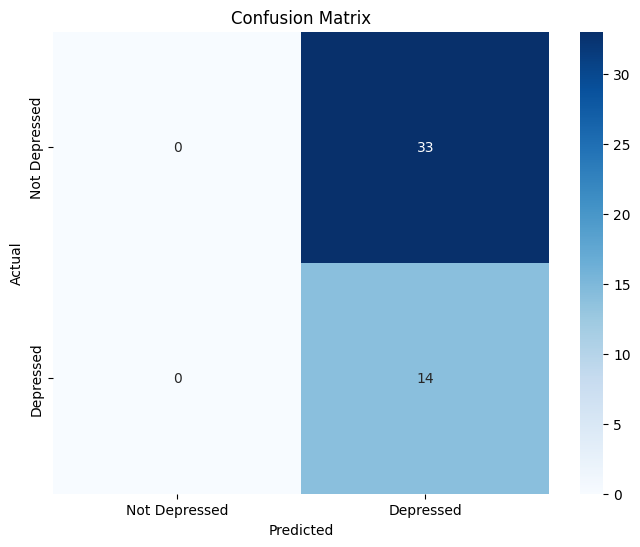

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def standard_normal_variate(data):
    mean = np.mean(data)
    std = np.std(data)

    return (data - mean) / std


def create_mfcc_delta(feature, concat=False):
    """
    Obtains the local differential (first and second order) of the MFCC

    Inputs
        feature: np.array - The MFCC to be used for the local differentials
        concat: bool - If True, the differentials will be concatenated rather
                than stacked

    Output
        mfcc: numpy.array - The Updated MFCC
    """
    mfcc_delta = librosa.feature.delta(feature)
    mfcc_delta2 = librosa.feature.delta(feature, order=2)

    if concat:
        mfcc = np.concatenate((feature, mfcc_delta, mfcc_delta2))
    else:
        mfcc = np.array((feature, mfcc_delta, mfcc_delta2))

    return mfcc


def mfcc(audio, sample_rate, freq_bins, window_size, hop_size,
         window_func=np.hanning(1024), snv=False):
    """
    Obtains the local differential (first and second order) of the MFCC

    Inputs
        audio: np.array - The audio data to be converted to MFCC
        sample_rate: int - The original sampling rate of the audio
        freq_bins: int - The number of mel bins
        window_size: int - The length of the window to be passed over the data
        hop_size: int - The gap between windows
        window: numpy - The type of window function to be used

    Output
        mfcc: numpy.array - The Updated MFCC
    """
    mfcc = librosa.feature.mfcc(y=audio,
                                sr=sample_rate,
                                n_mfcc=freq_bins,
                                n_fft=window_size,
                                hop_length=hop_size,
                                window=window_func)

    if snv:
        mfcc = standard_normal_variate(mfcc)

    return mfcc
